# Setup

In [3]:
import figure_utilities
import constants
from stats_utilities import test_balance, run_event_study
import matplotlib.pyplot as plt
from panel_utilities import get_value_variable_names, prepare_df_for_DiD
plt.rcParams['savefig.dpi'] = 300
import os
from stats_utilities import run_event_study
from differences import ATTgt
import pandas as pd
import numpy as np

In [1]:
# Store paths.
INPUT_DATA_PANEL = "../data/03_cleaned/crime_analysis_monthly.csv"
OUTPUT_TABLES = "../output/final_paper/tables"
OUTPUT_FIGURES = "../output/final_paper/figures"

# Main Results

In [12]:
# Read fresh copy of unrestricted dataset into memory.
df = pd.read_csv(INPUT_DATA_PANEL)
treatment_date_variable = 'latest_docket_month'  # Store treatment date variable.


In [13]:
# Generate value variables list and dictionaries mapping between months and integers.
analysis = f"group_0_crimes_{constants.Analysis.MAIN_RESULTS_RADIUS}m"
weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, analysis)

In [14]:
# Re-Balance on Controls
balance_table, pre_treatment_covariates = test_balance(df, analysis, OUTPUT_TABLES)
balance_table

\
                                                           Cases Won by Plaintiff (1)   
Panel A Total Incidents, 2018                                              333.363636   
        Total Incidents, Month -12 - Total Incidents, M...                 -14.027778   
        Total Incidents, 2019 - Total Incidents, 2018                       -2.046717   
Panel B Bachelor's degree, 2010                                              0.330414   
        Job density, 2013                                                18339.304431   
        Median household income, 2016                                    48690.489899   
        Poverty rate, 2010                                                   0.271480   
        Population density, 2010                                         22820.682895   
        Share white, 2010                                                    0.320060   
Panel C Filing for cause                                                     0.178030   
        Defendant has attorney                                               0.003788   
        Plaintiff has attorney                                               0.866162   
        Filing without cause                                                 0.040404   
        Filing for nonpayment                                                0.781566   

                                                           Difference in Cases Won by Defendant  \
                                                                                 Unweighted (2)   
Panel A Total Incidents, 2018                                                         -6.741259   
        Total Incidents, Month -12 - Total Incidents, M...                            -2.307498   
        Total Incidents, 2019 - Total Incidents, 2018                                 -1.455109   
Panel B Bachelor's degree, 2010                                                        0.016408   
        Job density, 2013                                                            575.202823   
        Median household income, 2016                                               4225.390598   
        Poverty rate, 2010                                                            -0.031377   
        Population density, 2010                                                    -924.949390   
        Share white, 2010                                                              0.012198   
Panel C Filing for cause                                                               0.078730   
        Defendant has attorney                                                        -0.052156   
        Plaintiff has attorney                                                        -0.066706   
        Filing without cause                                                          -0.015540   
        Filing for nonpayment                                                         -0.063190   

                                                                          \
                                                            \emph{p} (3)   
Panel A Total Incidents, 2018                               5.763603e-01   
        Total Incidents, Month -12 - Total Incidents, M...  4.572306e-01   
        Total Incidents, 2019 - Total Incidents, 2018       2.728326e-01   
Panel B Bachelor's degree, 2010                             1.460136e-01   
        Job density, 2013                                   8.065373e-01   
        Median household income, 2016                       1.153473e-03   
        Poverty rate, 2010                                  4.010476e-05   
        Population density, 2010                            2.062529e-01   
        Share white, 2010                                   3.844655e-01   
Panel C Filing for cause                                    1.083017e-05   
        Defendant has attorney                              1.026969e-09   
        Plaintiff has attorney                              1.882203e-05   
        Filin

## Crime Trends Around Filing Date

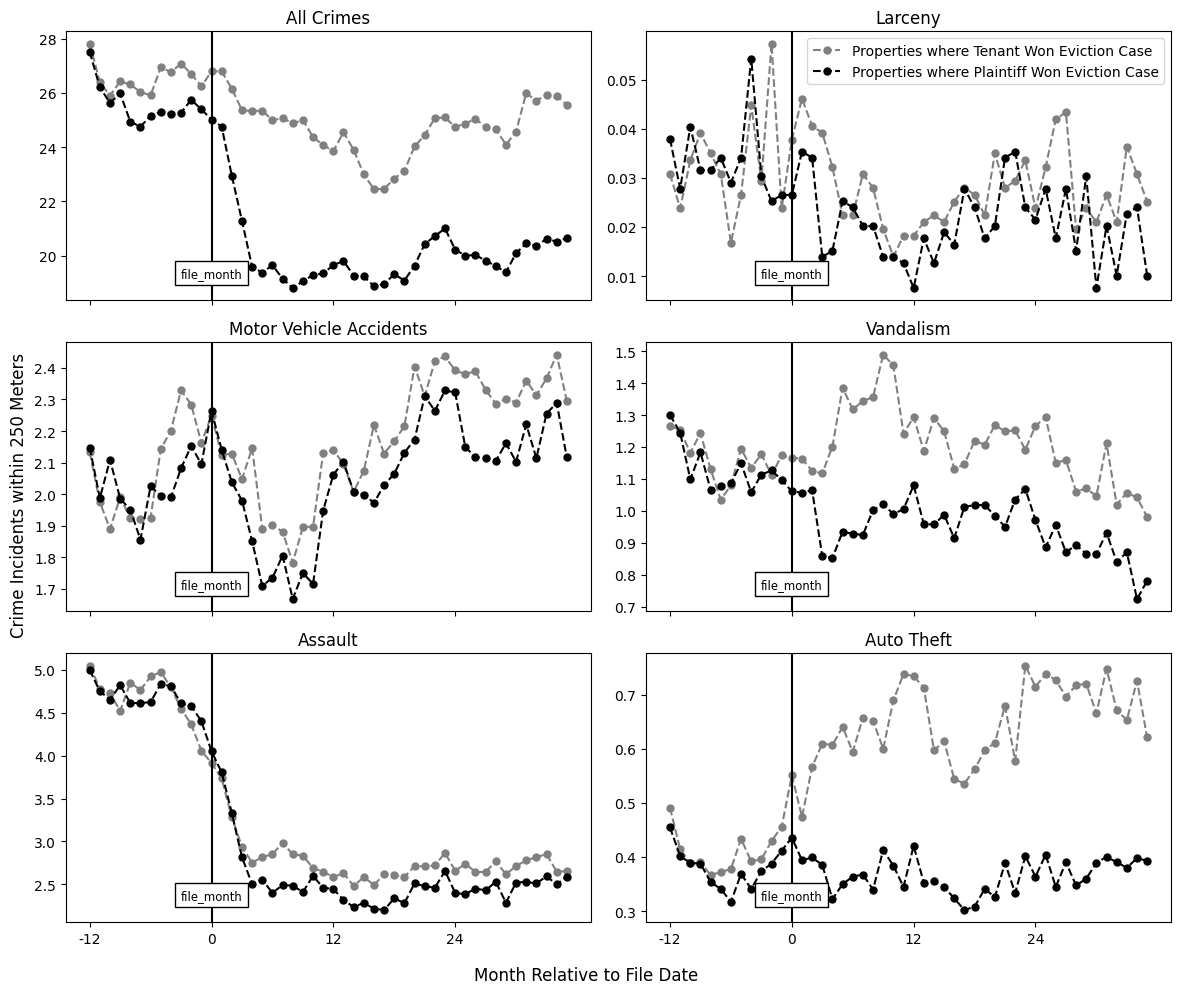

In [50]:
treatment_date_variable = 'file_month'
fig, axes = plt.subplots(3, 2, sharex=True, figsize=(12, 10), layout='constrained')
titles = ["All Crimes", "Larceny", "Motor Vehicle Accidents", "Vandalism", "Assault", "Auto Theft"]
for group, (ax, title) in enumerate(zip(axes.flat, titles)):
    df = pd.read_csv(INPUT_DATA_PANEL)
    result, _ = run_event_study(df,
                                treatment_date_variable,
                                f'group_{group}_crimes_{constants.Analysis.MAIN_RESULTS_RADIUS}m')
    
    month = []
    treatment = []
    control = []
    for i in range(constants.Analysis.MINIMUM_PRE_PERIOD, constants.Analysis.MAXIMUM_POST_PERIOD):
        month.append(i)
        control.append(result.params[f'month_{i}'] )
        treatment.append((result.params['judgment_for_plaintiff'] +
                           result.params[f'month_{i}_X_treatment_indicator'] +
                           result.params[f'month_{i}'] ))
    l2, = ax.plot(month,
        control,
        color='grey',
        linestyle='--',
        marker='o',
        markersize=5,
        label="Properties where Tenant Won Eviction Case")
    l1, = ax.plot(month,
            treatment,
            color='black',
            linestyle='--',
            marker='o',
            markersize=5,
            label="Properties where Plaintiff Won Eviction Case")
    if title == "Larceny":
        ax.legend(loc="upper right")

    label = treatment_date_variable.replace(" ", "\n")
    figure_utilities.plot_labeled_vline(ax, x=0, text=f"{label}", color='black', linestyle='-',
                           text_y_location_normalized=0.1)
    
    ax.set_title(title)
    ax.set_xticks(range(constants.Analysis.MINIMUM_PRE_PERIOD, constants.Analysis.MAXIMUM_POST_PERIOD, 12),
                  range(constants.Analysis.MINIMUM_PRE_PERIOD, constants.Analysis.MAXIMUM_POST_PERIOD, 12))
fig.supxlabel(f"Month Relative to File Date")
fig.supylabel(f"Crime Incidents within {constants.Analysis.MAIN_RESULTS_RADIUS} Meters")
plt.tight_layout()
plt.show()
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, f"crime_trends_around_{treatment_date_variable}.png"))

## Crime Trends Around Latest Docket Month

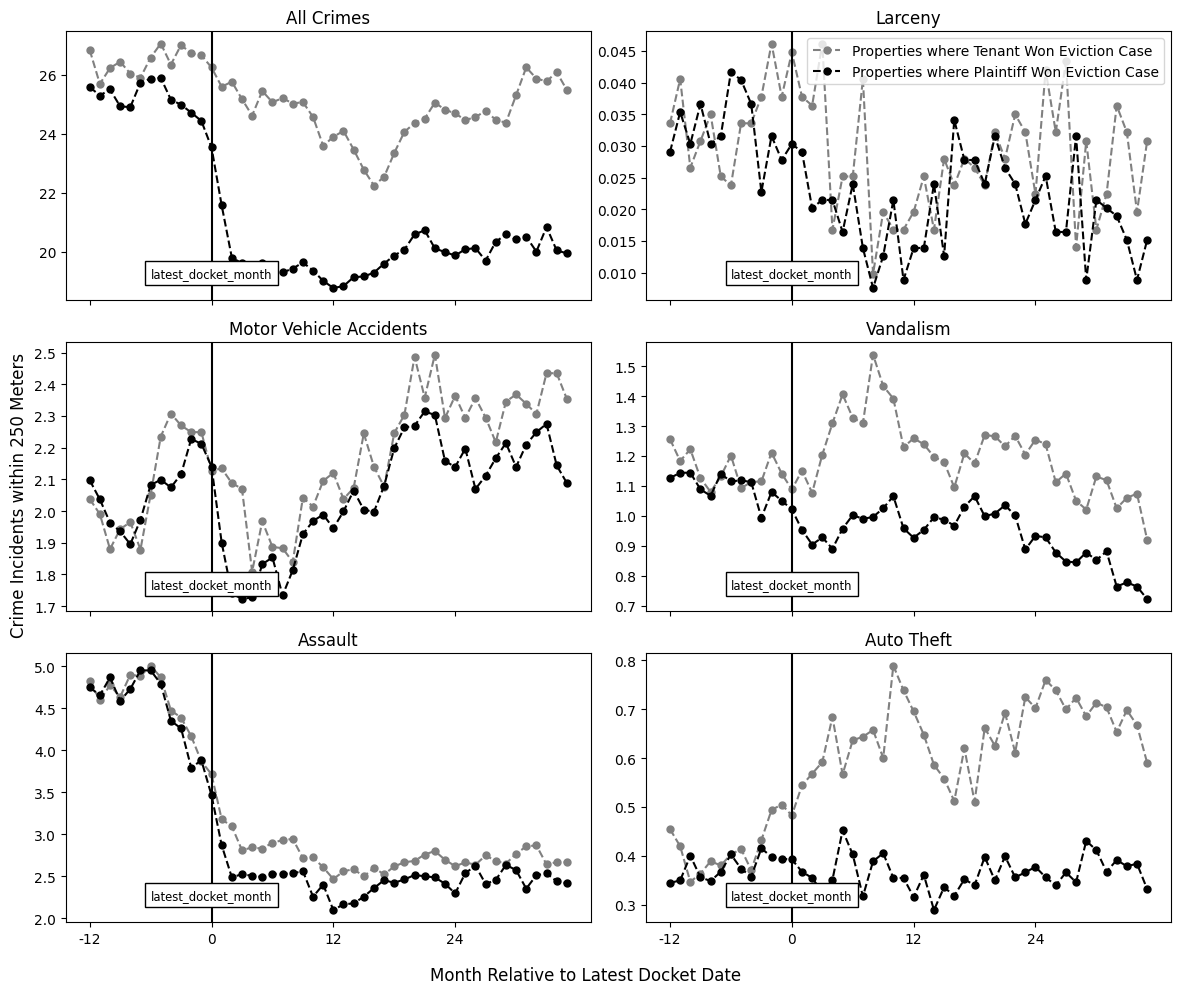

In [51]:
treatment_date_variable = 'latest_docket_month'
fig, axes = plt.subplots(3, 2, sharex=True, figsize=(12, 10), layout='constrained')
titles = ["All Crimes", "Larceny", "Motor Vehicle Accidents", "Vandalism", "Assault", "Auto Theft"]
for group, (ax, title) in enumerate(zip(axes.flat, titles)):
    df = pd.read_csv(INPUT_DATA_PANEL)
    result, _ = run_event_study(df,
                                treatment_date_variable,
                                f'group_{group}_crimes_{constants.Analysis.MAIN_RESULTS_RADIUS}m')
    
    month = []
    treatment = []
    control = []
    for i in range(constants.Analysis.MINIMUM_PRE_PERIOD, constants.Analysis.MAXIMUM_POST_PERIOD):
        month.append(i)
        control.append(result.params[f'month_{i}'] )
        treatment.append((result.params['judgment_for_plaintiff'] +
                           result.params[f'month_{i}_X_treatment_indicator'] +
                           result.params[f'month_{i}'] ))
    l2, = ax.plot(month,
        control,
        color='grey',
        linestyle='--',
        marker='o',
        markersize=5,
        label="Properties where Tenant Won Eviction Case")
    l1, = ax.plot(month,
            treatment,
            color='black',
            linestyle='--',
            marker='o',
            markersize=5,
            label="Properties where Plaintiff Won Eviction Case")
    if title == "Larceny":
        ax.legend(loc="upper right")

    label = treatment_date_variable.replace(" ", "\n")
    figure_utilities.plot_labeled_vline(ax, x=0, text=f"{label}", color='black', linestyle='-',
                           text_y_location_normalized=0.1)
    
    ax.set_title(title)
    ax.set_xticks(range(constants.Analysis.MINIMUM_PRE_PERIOD, constants.Analysis.MAXIMUM_POST_PERIOD, 12),
                  range(constants.Analysis.MINIMUM_PRE_PERIOD, constants.Analysis.MAXIMUM_POST_PERIOD, 12))
fig.supxlabel(f"Month Relative to Latest Docket Date")
fig.supylabel(f"Crime Incidents within {constants.Analysis.MAIN_RESULTS_RADIUS} Meters")
plt.tight_layout()
plt.show()
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, f"crime_trends_around_{treatment_date_variable}.png"))

In [52]:
file_month_point_estimates = []
file_month_p_values = []
latest_docket_month_point_estimates = []
latest_docket_month_p_values = []
for result, point_estimates, p_values in zip([result_file_month, result_latest_docket_month],
                                             [file_month_point_estimates, latest_docket_month_point_estimates],
                                             [file_month_p_values, latest_docket_month_p_values]):
    for i in range(constants.Analysis.MINIMUM_PRE_PERIOD, 0):
        hypothesis = f"month_{i}_X_treatment_indicator + judgment_for_plaintiff = 0"
        f_test = result.f_test(hypothesis)
        point_estimates.append(result.params[f'month_{i}_X_treatment_indicator'] + result.params['judgment_for_plaintiff'])
        p_values.append(f_test.pvalue)

    joint_significance_hypothesis = "=".join([f"month_{i}_X_treatment_indicator + judgment_for_plaintiff" for i in range(-12, 0)])
    p_values.append(result.f_test(joint_significance_hypothesis).pvalue)
    point_estimates.append(np.nan)


In [53]:
file_month_pretrends_test = pd.DataFrame({'$\\gamma_r + \\beta_0$ (1)': file_month_point_estimates,
                                              '\\textit{p} (2)': file_month_p_values}, index=list(range(-12, 0)) + ["$\\gamma_{-12} = ... = \\gamma_{-1}$"])
file_month_pretrends_test.index.name = "$r$"
file_month_pretrends_test = pd.concat([file_month_pretrends_test], axis=1, keys=["\\textit{File Date}"])

latest_docket_month_pretrends_test = pd.DataFrame({'$\\gamma_r + \\beta_0$ (3)': latest_docket_month_point_estimates,
                                              '\\textit{p} (4)': latest_docket_month_p_values}, index=list(range(-12, 0)) + ["$\\gamma_{-12} = ... = \\gamma_{-1} = 0$"])
latest_docket_month_pretrends_test.index.name = "$r$"
latest_docket_month_pretrends_test = pd.concat([latest_docket_month_pretrends_test], axis=1, keys=["\\textit{Latest Docket Date}"])


spacer = pd.concat([pd.DataFrame([[np.nan] for i in range(13)], index=latest_docket_month_pretrends_test.index, columns=[" "])], axis=1, keys=[""])

pretrends_test = pd.concat([file_month_pretrends_test, spacer, latest_docket_month_pretrends_test], axis=1)

In [54]:
# Export to LaTeX.
filename = os.path.join(OUTPUT_TABLES, "pretrends_test.tex")
latex = (pretrends_test
         .style
         .format("{:,.2f}", na_rep=" ")
         .to_latex(None,
                   column_format="lccccc",
                   multicol_align='c',
                   hrules=True,
                   clines="skip-last;data"))

latex = latex.split("\\\\\n")
latex.insert(1, "\\cline{2-3}\\cline{5-6}\n")
latex = "\\\\\n".join(latex)
with open(filename, 'w') as file:
    file.write(latex)

## Unconditional DiD

In [28]:
df = pd.read_csv(INPUT_DATA_PANEL)
df = prepare_df_for_DiD(df=df,
                        analysis=analysis,
                        treatment_date_variable=treatment_date_variable,
                        pre_treatment_covariates=[],
                        value_vars=weekly_value_vars_crime,
                        period_to_int_dictionary=month_to_int_dictionary)
# Run DiD conditional on covariates.
att_gt_all_crimes = ATTgt(data=df, cohort_name=treatment_date_variable, base_period='universal')
formula = f'{analysis}'
att_gt_all_crimes.fit(formula=formula, control_group='never_treated', n_jobs=-1, progress_bar=True)
# Plot D.R. ATT(t-g)s on a long horizon.
fig, ax = plt.subplots(layout='constrained')

figure_utilities.aggregate_by_event_time_and_plot(att_gt_all_crimes,
                                                  start_period=constants.Analysis.MINIMUM_PRE_PERIOD,
                                                  end_period=constants.Analysis.MAXIMUM_POST_PERIOD,
                                                  title="", ax=ax)

figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "att_gt_unconditional_all_crimes.png"))

## Doubly Robust DiD Conditional on Covariates

In [6]:
df = pd.read_csv(INPUT_DATA_PANEL)
df = prepare_df_for_DiD(df=df,
                        analysis=analysis,
                        treatment_date_variable=treatment_date_variable,
                        pre_treatment_covariates=pre_treatment_covariates,
                        value_vars=weekly_value_vars_crime,
                        period_to_int_dictionary=month_to_int_dictionary)
# Run DiD conditional on covariates.
att_gt_all_crimes = ATTgt(data=df, cohort_name=treatment_date_variable, base_period='universal')
formula = f'{analysis} ~ ' + '+'.join(pre_treatment_covariates)
att_gt_all_crimes.fit(formula=formula, control_group='never_treated', n_jobs=-1, progress_bar=True)
# Plot D.R. ATT(t-g)s on a long horizon.
fig, ax = plt.subplots(layout='constrained')

figure_utilities.aggregate_by_event_time_and_plot(att_gt_all_crimes,
                                                  start_period=constants.Analysis.MINIMUM_PRE_PERIOD,
                                                  end_period=constants.Analysis.MAXIMUM_POST_PERIOD,
                                                  title="", ax=ax)

figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "att_gt_dr_all_crimes.png"))

Computing ATTgt [workers=12]  100%|████████████████████| 980/980 [00:03<00:00, 264.96it/s]


In [11]:
# Non-Covid
df = pd.read_csv(INPUT_DATA_PANEL)
df = df.loc[~(df['latest_docket_month'].isin(['2019-12', '2020-01', '2020-02', '2020-03'])), :]
df = prepare_df_for_DiD(df=df,
                        analysis=analysis,
                        treatment_date_variable=treatment_date_variable,
                        pre_treatment_covariates=pre_treatment_covariates,
                        value_vars=weekly_value_vars_crime,
                        period_to_int_dictionary=month_to_int_dictionary)
# Run DiD conditional on covariates.
att_gt_all_crimes = ATTgt(data=df, cohort_name=treatment_date_variable, base_period='universal')
formula = f'{analysis} ~ ' + '+'.join(pre_treatment_covariates)
att_gt_all_crimes.fit(formula=formula, control_group='never_treated', n_jobs=-1, progress_bar=True)
# Plot D.R. ATT(t-g)s on a long horizon.
fig, ax = plt.subplots(layout='constrained')

figure_utilities.aggregate_by_event_time_and_plot(att_gt_all_crimes,
                                                  start_period=constants.Analysis.MINIMUM_PRE_PERIOD,
                                                  end_period=constants.Analysis.MAXIMUM_POST_PERIOD,
                                                  title="", ax=ax)

figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "att_gt_dr_non_covid.png"))

Computing ATTgt [workers=12]  100%|████████████████████| 588/588 [00:12<00:00, 47.52it/s]


## Heterogeneous Treatment Effects

In [ ]:
point_estimates = []
ci_uppers = []
ci_lowers = []
pretrend_p_values = []
for variable in ['popdensity2010', 'share_white2010', 'poor_share2010']:
    # Read fresh copy of unrestricted dataset into memory.
    df = pd.read_csv(INPUT_DATA_PANEL)

    # Generate indicator variable for above median value of current characteristic
    median = df[variable].median()
    above_median_indicator_name = f'above_median_{variable}'
    df.loc[:, above_median_indicator_name] = 0
    df.loc[df[variable] > median, above_median_indicator_name] = 1

    # Prepare DataFrame for DiD
    pre_treatment_covariates_minus_current_var = pre_treatment_covariates.copy()
    pre_treatment_covariates_minus_current_var.remove(variable)
    df = prepare_df_for_DiD(df=df,
                            analysis=analysis,
                            treatment_date_variable=treatment_date_variable,
                            pre_treatment_covariates=pre_treatment_covariates_minus_current_var + [above_median_indicator_name],
                            value_vars=weekly_value_vars_crime,
                            period_to_int_dictionary=month_to_int_dictionary)

    # Run DiD
    att_gt_by_sample = ATTgt(data=df,
                             cohort_name=treatment_date_variable,
                             base_period='universal')
    att_gt_by_sample.fit(formula=f'{analysis} ~ relative_pre_treatment_change_in_{analysis}',
                         control_group='never_treated',
                         split_sample_by=f'above_median_{variable}',
                         n_jobs=-1,
                         progress_bar=True)

    att_gt_by_sample = att_gt_by_sample.aggregate('event', overall=True)

    # Collect point estimates, confidence interval bounds
    below_median_point_estimate = att_gt_by_sample.loc[f'above_median_{variable} = 0', ("EventAggregationOverall", slice(None), "ATT")]
    point_estimates.append(below_median_point_estimate)
    above_median_point_estimate = att_gt_by_sample.loc[f'above_median_{variable} = 1', ("EventAggregationOverall", slice(None), "ATT")]
    point_estimates.append(above_median_point_estimate)

    below_median_ci_lower = att_gt_by_sample.loc[f'above_median_{variable} = 0', ("EventAggregationOverall", "pointwise conf. band", "lower")]
    ci_lowers.append(below_median_ci_lower)
    above_median_ci_lower = att_gt_by_sample.loc[f'above_median_{variable} = 1', ("EventAggregationOverall", "pointwise conf. band", "lower")]
    ci_lowers.append(above_median_ci_lower)

    below_median_ci_upper = att_gt_by_sample.loc[f'above_median_{variable} = 0', ("EventAggregationOverall", "pointwise conf. band", "upper")]
    ci_uppers.append(below_median_ci_upper)
    above_median_ci_upper = att_gt_by_sample.loc[f'above_median_{variable} = 1', ("EventAggregationOverall", "pointwise conf. band", "upper")]
    ci_uppers.append(above_median_ci_upper)



fig, ax = plt.subplots()
figure_utilities.plot_labeled_vline(ax, x=0, text="", color='black', linestyle='-')
for i, (ci_lower, ci_upper) in enumerate(zip(ci_lowers, ci_uppers)):
    ax.hlines(y=i, xmin=ci_lower, xmax=ci_upper, color='black')
ax.scatter(point_estimates, range(len(point_estimates)), color='black', s=7)
ax.set_yticks(ticks=range(len(point_estimates)),
              labels=["Below median population density, 2010",
                      "Above median population density, 2010",
                      "Below median share white, 2010",
                      "Above median share white, 2010",
                      "Below median share below poverty line, 2010",
                      "Above median share below poverty line, 2010"])
ax.set_ylabel("Sample Restriction")
ax.set_xlabel("Average Post-Treatment ATT")

figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "heterogenous_effects.png"))

## Calculating Treatment Effects Using Subset of Crimes as Outcome

In [6]:
# Larceny, Motor Vehicle Accidents,
df = pd.read_csv(INPUT_DATA_PANEL)
analysis = f'group_7_crimes_{constants.Analysis.MAIN_RESULTS_RADIUS}m'
# Get a list of months from the month_to_int_dictionary

_, month_to_int_dictionary, _ = get_value_variable_names(df, analysis)

# Get a list of pre-treatment covariates
_, pre_treatment_covariates = test_balance(df, analysis, None)

# Get value varaible names
weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, analysis)

df = prepare_df_for_DiD(df=df,
                        analysis=analysis,
                        treatment_date_variable=treatment_date_variable,
                        pre_treatment_covariates=pre_treatment_covariates,
                        value_vars=weekly_value_vars_crime,
                        period_to_int_dictionary=month_to_int_dictionary)
# Run DiD conditional on covariates.
att_no_effect_crimes = ATTgt(data=df, cohort_name=treatment_date_variable, base_period='universal')
formula = f'{analysis} ~ ' + '+'.join(pre_treatment_covariates)
result = att_no_effect_crimes.fit(formula=formula, control_group='never_treated', n_jobs=-1, progress_bar=True)

Computing ATTgt [workers=12]  100%|████████████████████| 980/980 [00:03<00:00, 270.21it/s]


In [7]:
# Assault, Investigations, Auto Theft, Vandalism
df = pd.read_csv(INPUT_DATA_PANEL)
analysis = f'group_8_crimes_{constants.Analysis.MAIN_RESULTS_RADIUS}m'

# Get a list of pre-treatment covariates
_, pre_treatment_covariates = test_balance(df, analysis, None)

# Get value varaible names
weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, analysis)

df = prepare_df_for_DiD(df=df,
                        analysis=analysis,
                        treatment_date_variable=treatment_date_variable,
                        pre_treatment_covariates=pre_treatment_covariates,
                        value_vars=weekly_value_vars_crime,
                        period_to_int_dictionary=month_to_int_dictionary)
# Run DiD conditional on covariates.
att_yes_effect_crimes = ATTgt(data=df, cohort_name=treatment_date_variable, base_period='universal')
formula = f'{analysis} ~ ' + '+'.join(pre_treatment_covariates)
result = att_yes_effect_crimes.fit(formula=formula, control_group='never_treated', n_jobs=-1, progress_bar=True)


Computing ATTgt [workers=12]  100%|████████████████████| 980/980 [00:03<00:00, 274.50it/s]


In [8]:
# Plot D.R. ATT(t-g)s for both subgroups of crimes
fig, (ax1, ax2) = plt.subplots(1, 2, layout='constrained', sharey=True)

figure_utilities.aggregate_by_event_time_and_plot(att_no_effect_crimes, start_period=constants.Analysis.MINIMUM_PRE_PERIOD,
                                                  end_period=constants.Analysis.MAXIMUM_POST_PERIOD,
                                                  title="All Crime Incidents as Outcome", ax=ax1)
figure_utilities.aggregate_by_event_time_and_plot(att_yes_effect_crimes, start_period=constants.Analysis.MINIMUM_PRE_PERIOD,
                                                  end_period=constants.Analysis.MAXIMUM_POST_PERIOD,
                                                  title="Subset of Crime Incidents as Outcome", ax=ax2)

figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "mechanism_analysis.png"))

## Alternative Radii

In [ ]:
fig, axes = plt.subplots(1, 3, layout='constrained', sharey=True)
radii = [constants.Analysis.MAIN_RESULTS_RADIUS, constants.Analysis.MAIN_RESULTS_RADIUS + 50, constants.Analysis.MAIN_RESULTS_RADIUS + 100]
atts = []
att_ses = []
twenty_seventeen_totals = []
att_labels = ['250m away', '300m away', '350m away', '250m and 350m away', '250m and 400m away']
for ax, radius in zip(axes, radii):
    if radius != constants.Analysis.MAIN_RESULTS_RADIUS:
        df = pd.read_csv(INPUT_DATA_PANEL)
        twenty_seventeen_totals.append(df[f'total_twenty_seventeen_group_0_crimes_{radius}m'].mean())
        analysis = f"group_0_crimes_{radius}m"
        weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, analysis)
        _, pre_treatment_covariates = test_balance(df, analysis)


        df = prepare_df_for_DiD(df=df,
                                analysis=analysis,
                                treatment_date_variable=treatment_date_variable,
                                pre_treatment_covariates=pre_treatment_covariates,
                                value_vars=weekly_value_vars_crime,
                                period_to_int_dictionary=month_to_int_dictionary)
        # Run DiD conditional on covariates.
        current_att_gt = ATTgt(data=df, cohort_name=treatment_date_variable, base_period='universal')
        formula = f'{analysis} ~ ' + '+'.join(pre_treatment_covariates)
        current_att_gt.fit(formula=formula, control_group='never_treated', n_jobs=-1, progress_bar=True)
        figure_utilities.aggregate_by_event_time_and_plot(current_att_gt,
                                                          start_period=constants.Analysis.MINIMUM_PRE_PERIOD,
                                                          end_period=constants.Analysis.MAXIMUM_POST_PERIOD,
                                                          title=f"{radius} Meters", ax=ax)
        atts.append(current_att_gt.aggregate('event', overall=True)['EventAggregationOverall']['']['ATT'].iloc[0])
        att_ses.append(current_att_gt.aggregate('event', overall=True)['EventAggregationOverall']['analytic']['std_error'].iloc[0])

    else:
        df = pd.read_csv(INPUT_DATA_PANEL)
        twenty_seventeen_totals.append(df[f'total_twenty_nineteen_group_0_crimes_{radius}m'].mean())
        figure_utilities.aggregate_by_event_time_and_plot(att_gt_all_crimes,
                                                          start_period=constants.Analysis.MINIMUM_PRE_PERIOD,
                                                          end_period=constants.Analysis.MAXIMUM_POST_PERIOD,
                                                          title=f"{radius} Meters", ax=ax)
        atts.append(att_gt_all_crimes.aggregate('event', overall=True)['EventAggregationOverall']['']['ATT'].iloc[0])
        att_ses.append(att_gt_all_crimes.aggregate('event', overall=True)['EventAggregationOverall']['analytic']['std_error'].iloc[0])


figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "att_gt_dr_alternative_radii.png"))

In [ ]:
for robustness_radius in constants.Analysis.ROBUSTNESS_RADII:
    df = pd.read_csv(INPUT_DATA_PANEL)
    twenty_seventeen_totals.append(df[f'total_twenty_nineteen_group_0_crimes_{robustness_radius}m'].mean())

    analysis = f"group_0_crimes_{robustness_radius}m"
    weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, analysis)
    _, pre_treatment_covariates = test_balance(df, analysis)

    df = prepare_df_for_DiD(df=df,
                            analysis=analysis,
                            treatment_date_variable=treatment_date_variable,
                            pre_treatment_covariates=pre_treatment_covariates,
                            value_vars=weekly_value_vars_crime,
                            period_to_int_dictionary=month_to_int_dictionary)

    # Run DiD conditional on covariates.
    att_gt_all_crimes_donut = ATTgt(data=df, cohort_name=treatment_date_variable, base_period='universal')
    formula = f'{analysis} ~ ' + '+'.join(pre_treatment_covariates)
    att_gt_all_crimes_donut.fit(formula=formula, control_group='never_treated', n_jobs=-1, progress_bar=True)


    atts.append(att_gt_all_crimes_donut.aggregate('event', overall=True)['EventAggregationOverall']['']['ATT'].iloc[0])
    att_ses.append(att_gt_all_crimes_donut.aggregate('event', overall=True)['EventAggregationOverall']['analytic']['std_error'].iloc[0])

In [ ]:
# Build table
atts_aggregated = pd.DataFrame()
atts_aggregated.loc[:, 'Treatment Effect (S.E.)'] = pd.Series(atts).round(2).astype(str) + " " + "(" + pd.Series(att_ses).round(2).astype(str) + ")"
atts_aggregated.loc[:, 'Total Incidents, 2017 (Mean Property)'] = pd.Series(twenty_seventeen_totals).round(2)
atts_aggregated.loc[:, 'Treatment Effect as \% of Mean'] = (-100 * (pd.Series(atts) / atts_aggregated['Total Incidents, 2017 (Mean Property)'])).round(2).astype(str)
atts_aggregated.loc[:, 'Total Incidents, 2017 (Mean Property)'] = atts_aggregated['Total Incidents, 2017 (Mean Property)'].astype(str)
atts_aggregated.index=att_labels
atts_aggregated = atts_aggregated.T

In [ ]:
# Reformat table
main_results_columns = ['250m away', '300m away', '350m away']
robustness_columns = ['250m and 350m away', '250m and 400m away']
main_estimates = pd.concat([atts_aggregated[main_results_columns]], axis=1, keys=["Crimes Less Than"])
robustness_estimates = pd.concat([atts_aggregated[robustness_columns]], axis=1, keys=["Crimes Between"])


In [ ]:
spacer = pd.concat([pd.DataFrame([[" "], [" "], [" "]], index=main_estimates.index, columns=[" "])], axis=1, keys=[""])
atts_aggregated = pd.concat([main_estimates, spacer, robustness_estimates], axis=1)

In [ ]:
latex = (atts_aggregated
                 .style
                 #.format(formatter="{:.2f}", subset=pd.IndexSlice[['Total Incidents, 2017 (Mean Property)', 'Treatment Effect as \% of Mean'], :])
                 .format_index("\\textit{{{}}}", escape="latex", axis=1, level=0)
                 .to_latex(None,
                           column_format="lcccccc",
                           hrules=True,
                           multicol_align='c',
                           clines="skip-last;data")).replace("{*}", "{.75cm}")
latex = latex.split("\\\\\n")
latex.insert(1, "\\cline{2-4}\\cline{6-7}\n")
latex = "\\\\\n".join(latex)
with open(os.path.join(OUTPUT_TABLES, "magnitudes_summary.tex"), 'w') as file:
    file.write(latex)